In [1]:
# # SBC - Pràctica CBR
# 
# - Aina Gomila
# - Ruth Parajó
# - Olivia Puig
# - Marc Ucelayeta

from cbr_modificat import CBR
import pickle
import pandas as pd
import numpy as np

cases =pd.read_pickle('../data/casos.pkl')
books = pd.read_pickle('../data/llibres.pkl')

with open('../data/clustering/model_clustering_casos.pkl', 'rb') as arxiu:
    clustering = pickle.load(arxiu)

In [2]:
#estableixo nou cas com el primer borrant els seus llibres recomanats (temporal)
casos_nous = cases.iloc[:102]
cases = cases.iloc[102:]
llibres_recomanats_baseline = casos_nous['llibres_recomanats'].copy()
puntuacions_llibres_baseline = casos_nous['puntuacions_llibres'].copy()
for i,_ in casos_nous.iterrows():
    casos_nous.at[i,'llibres_recomanats'] = []
    casos_nous.at[i,'puntuacions_llibres'] = []

cbr = CBR(cases, clustering, books)

In [3]:
puntuacions = []
llibres_recomanats = []
puntuacions_llibres = []
for i,cas in casos_nous.iterrows():
    print('Nou cas',i)
    recomanacio = cbr.recomana(cas)
    print('Recomanació final:')
    for llibre in recomanacio.llibres_recomanats:
        print(books[books.book_id==int(llibre)]['title'].iloc[0])
        #cbr.justificacio(cas)
    puntuacions.append(recomanacio.puntuacions_llibres)
    llibres_recomanats.append(recomanacio.llibres_recomanats)
    puntuacions_llibres.append(recomanacio.puntuacions_llibres)
    print('\n')

Nou cas 0
he entrat
he entrat
he entrat
A continuació, et demanarem algunes preferències per millorar la recomanació.
Quina puntuació li donaries a la recomanació del llibre The Book of Night Women? (0-5) 
3
Quina puntuació li donaries a la recomanació del llibre I Am the Messenger? (0-5) 
4
Quina puntuació li donaries a la recomanació del llibre The Last Town (Wayward Pines, #3)? (0-5) 
3
Recomanació final:
The Book of Night Women
I Am the Messenger
The Last Town (Wayward Pines, #3)


Nou cas 1
he entrat
he entrat
he entrat
A continuació, et demanarem algunes preferències per millorar la recomanació.
Quina puntuació li donaries a la recomanació del llibre Queste (Septimus Heap, #4)? (0-5) 
4
Quina puntuació li donaries a la recomanació del llibre The Infinite Book: A Short Guide to the Boundless, Timeless and Endless? (0-5) 
5
Quina puntuació li donaries a la recomanació del llibre My Sunshine Away? (0-5) 
4
Recomanació final:
Queste (Septimus Heap, #4)
The Infinite Book: A Short Guid

Puntuació mitjana: 3.892156862745098
Desviació estàndard: 0.9759211778257093


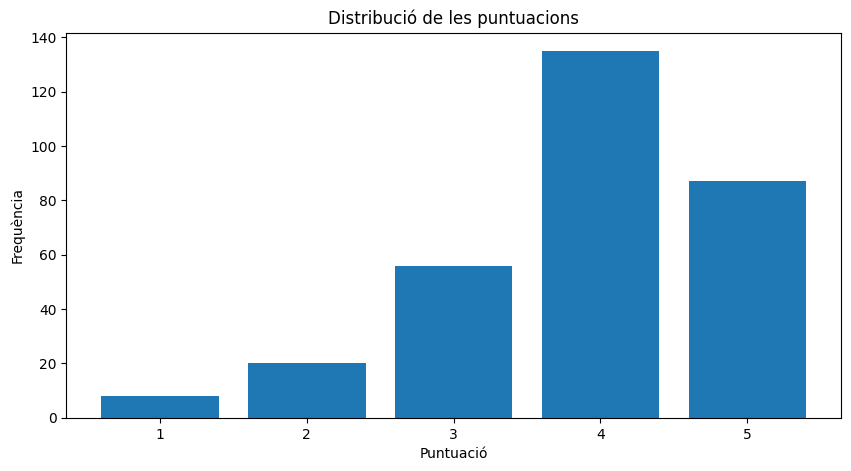

In [4]:
# Flatten puntuacions
puntuacions = np.array(puntuacions)
puntuacions = puntuacions.flatten()
puntuacions_s = [str(p) for p in puntuacions]

# Plot barplot of puntuacions x the puntuation y the frequency
import matplotlib.pyplot as plt
from collections import Counter
# Ordenar "1", "2", "3", "4", "5"
puntuacions_s = sorted(puntuacions_s)
# Contar frecuencias
puntuacions_s = Counter(puntuacions_s)
# Plot
plt.figure(figsize=(10,5))
plt.bar(puntuacions_s.keys(), puntuacions_s.values())
plt.title('Distribució de les puntuacions')
plt.xlabel('Puntuació')
plt.ylabel('Frequència')
plt.savefig('../plots/puntuacions_recomanacions.png')

# Print mean and std
print('Puntuació mitjana:', np.mean(puntuacions))
print('Desviació estàndard:', np.std(puntuacions))

In [5]:
llibres_recomanats_baseline

0      [18306845, 9577969, 377916]
1        [7824322, 140082, 110494]
2         [3227063, 42899, 476692]
3            [8573020, 33512, 930]
4          [10572, 13496, 8058301]
                  ...             
97     [128029, 6962314, 13153972]
98      [22557272, 18007564, 3985]
99               [865, 6900, 3431]
100      [1967737, 5556466, 53496]
101       [2782082, 14050, 206682]
Name: llibres_recomanats, Length: 102, dtype: object

In [20]:
# Elabora una matriz de confusión de cluster x cluster
# Sumaremos 1 si el libro recomendado esta en el cluster del libro real y 0 si no
# Coger clusters de los libros de llibres_recomanats_baseline
clusters_recomanats_baseline = []
for llibres in llibres_recomanats_baseline:
    clusters = []
    for i, llibre in enumerate(llibres):
        if i != 2:
            cluster = books[books.book_id==int(llibre)].iloc[0]
            clusters.append(cluster)
    clusters_recomanats_baseline.append(clusters)

clusters_recomanats = []
for llibres in llibres_recomanats:
    clusters = []
    for i, llibre in enumerate(llibres):
        if i != 2:
            cluster = books[books.book_id==int(llibre)].iloc[0]
            clusters.append(cluster)
    clusters_recomanats.append(clusters)

In [23]:
np.array(clusters_recomanats_baseline).shape

(102, 2, 23)

In [19]:
np.array(clusters_recomanats).shape

(102, 2, 23)

In [26]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import DistanceMetric
def similarity(user, case, metric):
    # case haurà de ser el num de cas dins dataframe
    if metric == "hamming":
        # Hamming distance
        dist = DistanceMetric.get_metric('hamming')
        return dist.pairwise(user.vector.reshape(1,-1), np.array(case.vector).reshape(1,-1))[0][0]
    elif metric == "cosine":
        user_vector_np = np.array(user.vector).reshape(1, -1)
        case_vector_np = np.array(case.vector).reshape(1,-1)
        return cosine_similarity(user_vector_np, case_vector_np)[0][0]

In [34]:
mean_sim = []
mean_full = []
for i in range(len(clusters_recomanats)):
    # Calculamos la similitud de coseno
    sim_1_1 = similarity(clusters_recomanats_baseline[i][0], clusters_recomanats[i][0], "cosine")
    sim_1_2 = similarity(clusters_recomanats_baseline[i][0], clusters_recomanats[i][1], "cosine")
    sim_2_1 = similarity(clusters_recomanats_baseline[i][1], clusters_recomanats[i][0], "cosine")
    sim_2_2 = similarity(clusters_recomanats_baseline[i][1], clusters_recomanats[i][1], "cosine")
    mean = (sim_1_1 + sim_1_2 + sim_2_1 + sim_2_2) / 4
    mean = np.max([sim_1_1, sim_1_2, sim_2_1, sim_2_2])
    mean_full.append(np.array([sim_1_1, sim_1_2, sim_2_1, sim_2_2]))
    mean_sim.append(mean)

In [36]:
mean_sim = np.array(mean_sim)
mean_full = np.array(mean_full)
mean_sim

array([0.64588091, 0.51832706, 0.80382133, 0.48627152, 0.69714996,
       0.82510965, 0.74039459, 0.72143898, 0.63518225, 0.7250886 ,
       0.66313109, 0.76323571, 0.55401399, 0.42102939, 0.75248968,
       0.8123851 , 0.62739895, 0.62746002, 0.6024969 , 0.49103532,
       0.47821055, 0.59374504, 0.40963248, 0.75478603, 0.61172898,
       0.55687501, 0.67458977, 0.39008933, 0.64539509, 0.4527045 ,
       0.73702084, 0.59113043, 0.64215515, 0.53197846, 0.63528116,
       0.56772423, 0.69285424, 0.69939999, 0.6003041 , 0.75794106,
       0.49416045, 0.4708064 , 0.67308766, 0.58930775, 0.51101867,
       0.74720307, 0.65211065, 0.47452805, 0.5707122 , 0.69491232,
       0.55824595, 0.72980741, 0.74039459, 0.70496639, 0.74019408,
       0.56050863, 0.58319294, 0.60042673, 0.6369889 , 0.42298609,
       0.6127879 , 0.66971623, 0.62398284, 0.69071877, 0.55748899,
       0.84893879, 0.54974373, 0.90166306, 0.47715887, 0.42137602,
       0.6480517 , 0.93168933, 0.67925263, 0.70275502, 0.61698

In [37]:
np.mean(mean_sim)

0.6435288982853137